In [1]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt

In [2]:
inferenceLocations = ['returnPSD','Time-Only','noReturnPSD']
vibSamples = ['4096','8192','16384','32768','65536']
vibSampleLabels = [r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$',r'$2^{16}$']

basePath = 'Edge-Device-Latency/No-Vib/Beaglebone_'
deviceId = 'Amazon-EC2'
numSamples = 750
numColumns = 3

extractLatency = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
inferenceLatency = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
columns = None

for i in range(len(vibSamples)):
    for j in range(len(inferenceLocations)):
        thisDF = pd.read_csv(basePath + inferenceLocations[j] +'_' + vibSamples[i] + '.csv')
        extractLatency[:,j,i] = thisDF.values[-numSamples:,-1]


mean latency, max latency, Max Score Difference, MSE

In [6]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
  
def bar_chart_compare(data,labels,dataLabels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',max_cutoff=0,min_cutoff=0,
             xtickpad=5,showfliers=False,legend_loc='best',extension='png'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    x = np.arange(data.shape[-1])
    tickPositions = x.tolist() 
    phantomLines = []
    width = .7 / len(dataLabels)
        
    means = np.mean(data,axis=0)
    stdev = np.std(data,axis=0)


    for j in range(data.shape[-2]):

        plt.bar(x - 0.35 + (j+.5) * width, means[j,:], width, label=r'\textbf{' + dataLabels[j] + '}')

    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    plt.legend(loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.' + extension,transparent=transparent)

    plt.show()
    

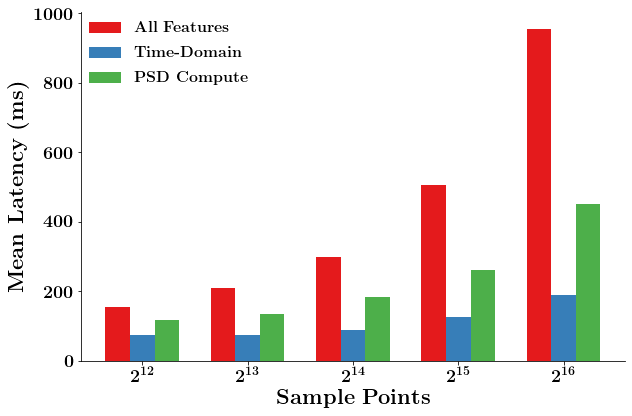

In [7]:
bar_chart_compare((extractLatency),vibSampleLabels,['All Features','Time-Domain','PSD Compute'],savefig=True,filename='Edge_ExtractLatency',
         template='presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Mean Latency (ms)',
         showfliers=False,legend_loc='upper left',
         log_y=False,extension='svg')
